# GraphSAGE implementation to the problem of electromagnetic showers recognition

**GraphSAGE** is a general inductive framework that leverages node feature information (e.g., text attributes) to efficiently generate node embeddings for previously unseen data. Instead of training individual embeddings for each node, we learn a function that generates embeddings by sampling and aggregating features from a node’s local neighborhood

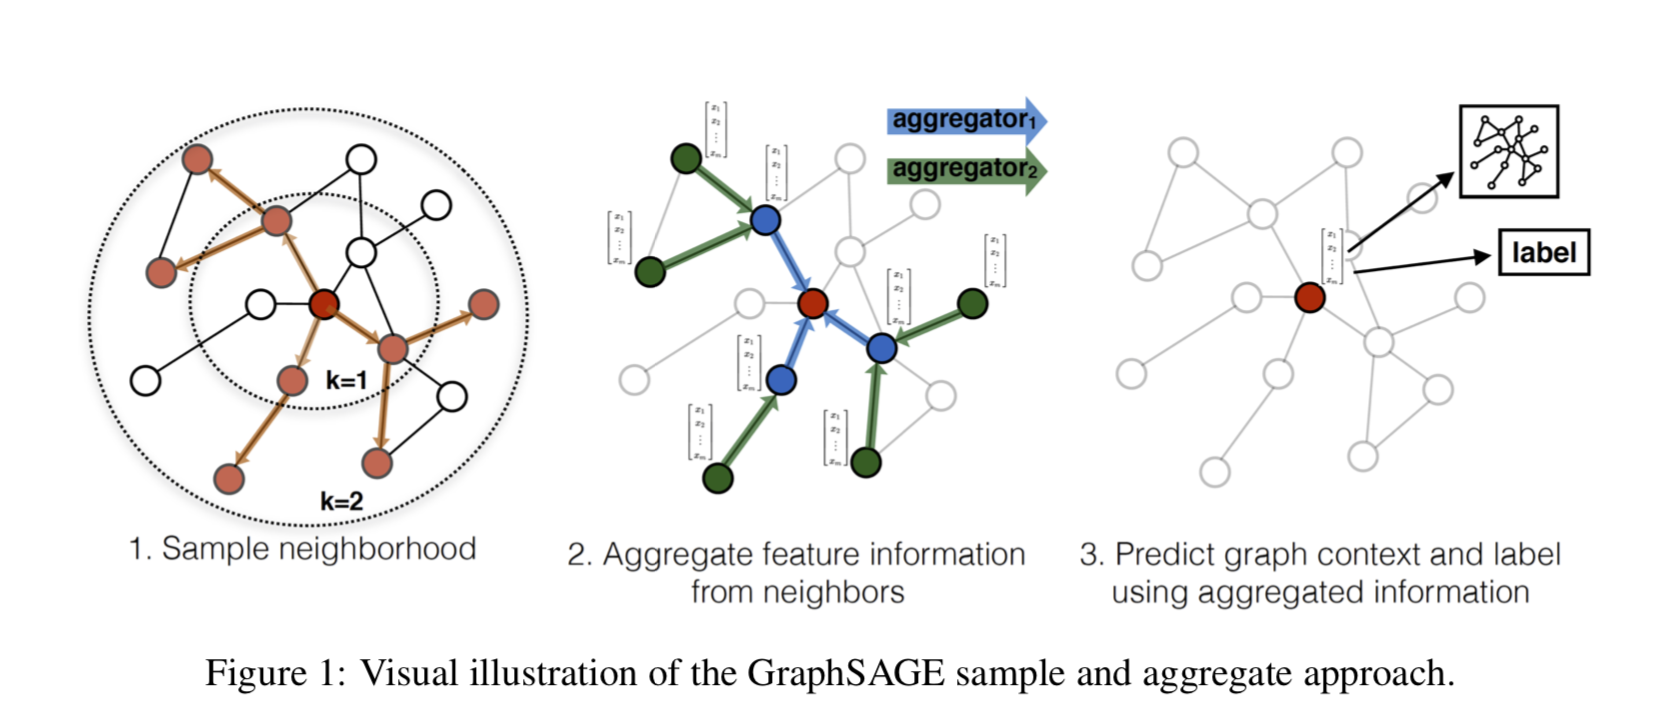

In [396]:
from IPython.display import Image
Image("GraphSage.png")

## Import libraries 

In [ ]:
# Sample solution is based on nontebooks by Artem Borzov

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import tables as tb
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import glob

%pylab inline

## Group close tracks from neighbour plates into pairs

This is crutial for constructing adjacency list, which drastically improves computational efficiency

In [ ]:
feat_XY = ['X', 'Y']

In [347]:
def add_neighbours(df, k, metric='minkowski'):

    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z'] + ['index']:
                    z_copy[col + '_pair'] = data[col].values                    
                res.append(z_copy)
       
        res.append(z_next)
   
    res = pd.concat(res)
    return res, i

def balance_train(df, k):

    data, i = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

## Data loading

In [348]:
train = []
for file in glob.glob('training/open*.h5')[:2]:# just 2 bricks  
    df = pd.read_hdf(file).drop(['TX', 'TY'], 1)
    df = df.reset_index()
    train.append(balance_train(df, k=1))
train = pd.concat(train)

100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


## Preprocessing

In [349]:
train = train.drop(['data_ind','event_id'], 1)

train = train.drop_duplicates()

len(train)

619654

In [350]:
train.dropna(inplace=True)

In [351]:
train.head()

,X,X_pair,Y,Y_pair,Z,Z_pair,index,index_pair,signal
0,49545.425781,49540.316406,58027.636719,58018.058594,5172.000000,5427.205078,768,660134.0,1.0
1,49540.316406,49611.359375,58018.058594,58146.925781,5427.205078,6465.000000,660134,435360.0,1.0
2,60857.125000,60936.945312,34515.269531,34540.082031,6465.000000,6702.123047,112797,48424.0,1.0
3,49611.359375,60936.945312,58146.925781,34540.082031,6465.000000,6702.123047,435360,48424.0,1.0
4,60936.945312,61099.531250,34540.082031,34405.531250,6702.123047,7758.000000,48424,355831.0,1.0


## Adjacency list formalization

In [352]:
INDEX = train[['index', 'index_pair']]
INDEX.index_pair = INDEX.index_pair.astype(int)
INDEX = INDEX.sort_values(['index']).reset_index(drop=True)
INDEX = INDEX.values

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [386]:
INDEX

array([[      48,   834176],
       [     392,  1614936],
       [     504,  5581176],
       ...,
       [55914952, 53027480],
       [55914960, 52420632],
       [55915048, 52954104]])

------------

## Dataset subsample

In [360]:
Train = train[465000:470000]

In [361]:
Train.signal.describe()

count    5000.000000
mean        0.174200
std         0.379307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: signal, dtype: float64

In [362]:
Train = Train.rename(index=str, columns={"index": "Index"})

In [363]:
Train.head()

,X,X_pair,Y,Y_pair,Z,Z_pair,Index,index_pair,signal
150104,61583.300781,61524.753906,54853.460938,54916.226562,68529.0,69822.0,6843073,6480832.0,1.0
150105,54550.203125,54660.171875,43318.363281,43307.078125,68529.0,69822.0,6843157,6977269.0,1.0
150106,61911.035156,61909.175781,54718.203125,54781.664062,68529.0,69822.0,6843806,6339263.0,1.0
150107,41302.972656,41384.960938,27690.273438,27838.605469,68529.0,69822.0,6845260,6792449.0,1.0
150108,54414.695312,54401.687500,43357.937500,43298.750000,68529.0,69822.0,6851690,6902415.0,1.0


In [364]:
ids = Train.Index

In [365]:
len(ids.unique())

5000

In [366]:
label = Train.signal.values
len(label)

5000

## Feature graph construction

In [367]:
from sklearn.neighbors import kneighbors_graph
G = kneighbors_graph(Train[['X', 'Y', 'Z']].values, 2, include_self=True)
G.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [368]:
G.shape

(5000, 5000)

# Building a model

In [323]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable

import numpy as np
import time
import random
from sklearn.metrics import f1_score, roc_auc_score
from collections import defaultdict

from graphsage.encoders import Encoder
from graphsage.aggregators import MeanAggregator


In [390]:
"""
Simple supervised GraphSAGE model as well as examples running the model
on the Cora and Pubmed datasets.
"""

class SupervisedGraphSage(nn.Module):

    def __init__(self, num_classes, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.xent = nn.CrossEntropyLoss()

        self.weight = nn.Parameter(torch.FloatTensor(num_classes, enc.embed_dim))
        init.xavier_uniform(self.weight)

    def forward(self, nodes):
        embeds = self.enc(nodes)
        scores = self.weight.mm(embeds)
        return scores.t()

    def loss(self, nodes, labels):
        scores = self.forward(nodes)
        return self.xent(scores, labels.squeeze())

def load_data(feat_data, labels, ids, INDEX):
    num_nodes = 5000
    node_map = {}
    
    for node in range(num_nodes): 
        node_map[ids[node]] = node
        


    adj_lists = defaultdict(set)
    
    for line in INDEX:
        try:
            paper1 = node_map[int(line[0])]
            paper2 = node_map[int(line[1])]
            adj_lists[paper1].add(paper2)
            adj_lists[paper2].add(paper1)
        except KeyError:
            continue
    #print('feat_data shape:',feat_data.shape,'\n label:', labels.shape,'\n adj_lists :', len(adj_lists))
    return feat_data, labels, adj_lists


def run(feat_data, labels, ids, INDEX):
    np.random.seed(1)
    random.seed(1)
    num_nodes = 5000
    feat_data, labels, adj_lists = load_data(feat_data, labels, ids, INDEX)
    features = nn.Embedding(5000, 5000)
    features.weight = nn.Parameter(torch.FloatTensor(feat_data.toarray()), requires_grad=False)
   # features.cuda()

    agg1 = MeanAggregator(features, cuda=True)
    enc1 = Encoder(features, 5000, 128, adj_lists, agg1, gcn=True, cuda=False)
    agg2 = MeanAggregator(lambda nodes : enc1(nodes).t(), cuda=False)
    enc2 = Encoder(lambda nodes : enc1(nodes).t(), enc1.embed_dim, 128, adj_lists, agg2,
            base_model=enc1, gcn=True, cuda=False)
    enc1.num_samples = 5
    enc2.num_samples = 5

    graphsage = SupervisedGraphSage(7, enc2)
#    graphsage.cuda()
    rand_indices = np.random.permutation(num_nodes)
    test = rand_indices[:1000]
    val = rand_indices[1000:1500]
    train = list(rand_indices[1500:])

    optimizer = torch.optim.SGD(filter(lambda p : p.requires_grad, graphsage.parameters()), lr=0.7)
    times = []
    for batch in range(100):
        batch_nodes = train[:256]
        random.shuffle(train)
        start_time = time.time()
        optimizer.zero_grad()
        loss = graphsage.loss(batch_nodes, 
                Variable(torch.LongTensor(labels[np.array(batch_nodes)])))
        loss.backward()
        optimizer.step()
        end_time = time.time()
        times.append(end_time-start_time)
       # print (batch, loss.data[0])

    val_output = graphsage.forward(val) 
    print ("Validation F1:", f1_score(labels[val], val_output.data.numpy().argmax(axis=1), average="micro"))
    print ("Average batch time:", np.mean(times))


if __name__ == "__main__":
    run(G, label, ids, INDEX)

/Users/katetrofimova/Desktop/Coursera/Addressing Large Hadron Collider Challenges by Machine Learning/week 4/graphsage/encoders.py:31: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  init.xavier_uniform(self.weight)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


Validation F1: 0.8140000000000001
Average batch time: 0.0053794956207275394
